In [1]:
using Pkg
Pkg.add(["NCDatasets", "Statistics", "StatsBase", "HypothesisTests", "Dates", 
    "ProgressMeter", "Plots", "DataFrames", "Distributions", "GLMakie"])

    Updating registry at `C:\Users\arikt\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\arikt\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\arikt\.julia\environments\v1.10\Manifest.toml`


In [2]:
# Required packages
using NCDatasets
using Statistics
using Dates
using DataFrames
using StatsBase
using Plots
using ProgressMeter
using HypothesisTests
using Printf

"""
Process NetCDF models with chunked latitude processing
"""
function process_models_chunked_lat(directory_path::String, rcp_value::String, return_period_value::String, set_num_chunks::Integer)
    # List all files in the directory
    all_files = readdir(directory_path, join=true)
    println("Total files found in directory: ", length(all_files))

    # Filter for .nc4 files
    nc4_files = filter(f -> endswith(f, ".nc4"), all_files)
    println("Files with .nc4 extension: ", length(nc4_files))

    # Filter files containing both rcp_value and return_period_value anywhere in the filename
    matching_files = filter(nc4_files) do f
        basename_f = basename(f)
        contains(basename_f, rcp_value) && contains(basename_f, return_period_value)
    end

    println("Files matching RCP '$(rcp_value)' and return period '$(return_period_value)': ", length(matching_files))
    if !isempty(matching_files)
        println("Example matching file: ", basename(matching_files[1]))
    end

    isempty(matching_files) && error("No files found matching criteria. Please check the directory path and file naming pattern.")

 
        
    # Get dimensions from first file
    ds = Dataset(matching_files[1])
    time_var = ds["time"][:]  # Changed from 'time' to 'time_var'
    lat = ds["lat"][:]
    lon = ds["lon"][:]
    close(ds)

    num_models = length(matching_files)
    num_time = length(time_var)  # Changed from 'time' to 'time_var'
    num_lat = length(lat)
    num_lon = length(lon)

    # Initialize result array
    result = Array{Float32}(undef, num_lat, num_lon, 9, num_models)

    # Set chunk size
    chunk_size_lat = ceil(Int, num_lat / set_num_chunks)

    # Process each model
    @showprogress "Processing models" for (model_idx, file) in enumerate(matching_files)
        println("Processing model $model_idx of $num_models: $(basename(file))")
        ds = Dataset(file)
        
        # Process in latitude chunks
        lat_indices = 1:chunk_size_lat:num_lat
        
        @showprogress "Processing latitude chunks" for (chunk_idx, lat_start) in enumerate(lat_indices)
            lat_end = min(lat_start + chunk_size_lat - 1, num_lat)
            lat_count = lat_end - lat_start + 1
            
            # Calculate total iterations for this chunk
            total_iterations = lat_count * num_lon
            iteration_counter = 0
            last_update_time = time_ns()  # Using time_ns() instead of time()
            update_interval = 300 * 1e9  # 300 seconds in nanoseconds
            
            # Read chunk data
            flddph_chunk = permutedims(
                ds["flddph"][:, lat_start:lat_end, :],
                [2, 1, 3]
            )
            
            
            # Process each grid point in chunk
            for i in 1:lat_count
                for j in 1:num_lon
                    iteration_counter += 1
                    
                    # Process data
                    data_ts = flddph_chunk[i, j, :]
                    
                    # Convert Missing to Float32 and handle NaN
                    data_ts_float = Float32[ismissing(x) ? NaN : Float32(x) for x in data_ts]
                    valid_idx = findall(!isnan, data_ts_float)
                    valid_data = data_ts_float[valid_idx]
                    length_valid_data = length(valid_data)
                    
                    if length_valid_data >= 2
                        # Calculate quantiles regardless of uniqueness
                        first_40 = valid_data[1:min(40, length_valid_data)]
                        last_40 = valid_data[(length_valid_data - 40):length_valid_data]
                        result[lat_start+i-1, j, 1, model_idx] = quantile(first_40, 0.05)
                        result[lat_start+i-1, j, 2, model_idx] = quantile(first_40, 0.25)
                        result[lat_start+i-1, j, 3, model_idx] = quantile(first_40, 0.50)
                        result[lat_start+i-1, j, 4, model_idx] = quantile(first_40, 0.75)
                        result[lat_start+i-1, j, 5, model_idx] = quantile(first_40, 0.95)
                        
                        result[lat_start+i-1, j, 6, model_idx] = quantile(last_40, 0.95) - quantile(last_40, 0.05)
                        result[lat_start+i-1, j, 7, model_idx] = quantile(last_40, 0.75) - quantile(last_40, 0.25)

                        if length(unique(valid_data)) > 1
                            # Calculate slope and correlation only if there's variability
                            slopes = Float32[]
                            for i1 in 1:length(valid_idx)
                                for i2 in (i1+1):length(valid_idx)
                                    push!(slopes, (valid_data[i2] - valid_data[i1]) / (valid_idx[i2] - valid_idx[i1]))
                                end
                            end
                            result[lat_start+i-1, j, 8, model_idx] = median(slopes)
                            
                            # Correlation test
                            test = CorrelationTest(Float32.(valid_idx), valid_data)
                            result[lat_start+i-1, j, 9, model_idx] = pvalue(test)
                        else
                            # Set slope and p-value to NaN when no variability
                            result[lat_start+i-1, j, 8:9, model_idx] .= NaN
                        end
                        
                        # Print status update every 5 minutes
                        current_time = time_ns()
                        if current_time - last_update_time > update_interval
                            progress = iteration_counter / total_iterations * 100
                            println("\nStatus Update:")
                            println("Processing model $model_idx of $num_models: $(basename(file))")
                            @printf("Progress: %.2f%%\n", progress)
                            println("Current values at position ($i, $j):")
                            println("  25th percentile: $(result[lat_start+i-1, j, 2, model_idx])")
                            println("  Median: $(result[lat_start+i-1, j, 3, model_idx])")
                            println("  75th percentile: $(result[lat_start+i-1, j, 4, model_idx])")
                            println("  Theil-Sen slope: $(result[lat_start+i-1, j, 8, model_idx])")
                            println("  Correlation p-value: $(result[lat_start+i-1, j, 9, model_idx])\n")
                            last_update_time = current_time
                        end
                    else
                        # Handle cases with insufficient data
                        result[lat_start+i-1, j, :, model_idx] .= NaN
                    end
                end
            end            
            GC.gc() # Garbage collection
        end
        close(ds)
    end    
    return result, lat, lon
end

"""
Save results to NetCDF file
"""
function save_to_netcdf_old(result, lat, lon, output_path, rcp_value, return_period_value)
    ds = Dataset(output_path, "c")
    
    # Define dimensions
    defDim(ds, "lat", length(lat))
    defDim(ds, "lon", length(lon))
    defDim(ds, "value", size(result, 3))
    defDim(ds, "model", size(result, 4))
    
    # Define variables
    v = defVar(ds, "result", Float32, ("lat", "lon", "value", "model"))
    v[:,:,:,:] = result
    
    # Add attributes
    ds.attrib["title"] = "Results Array Containing Statistical Analysis"
    ds.attrib["creation_date"] = string(now())
    
    close(ds)
end


function save_to_netcdf(result, lat, lon, output_path, rcp_value, return_period_value)
    ds = Dataset(output_path, "c")
    
    # Define dimensions
    defDim(ds, "lat", length(lat))
    defDim(ds, "lon", length(lon))
    defDim(ds, "value", size(result, 3))
    defDim(ds, "model", size(result, 4))
    
    # Define coordinate variables
    lat_var = defVar(ds, "lat", Float32, ("lat",))
    lon_var = defVar(ds, "lon", Float32, ("lon",))
    lat_var[:] = lat
    lon_var[:] = lon
    
    # Define main variable
    v = defVar(ds, "result", Float32, ("lat", "lon", "value", "model"))
    v[:,:,:,:] = result
    
    # Add attributes
    ds.attrib["title"] = "Results Array Containing Statistical Analysis"
    ds.attrib["creation_date"] = string(now())
    
    close(ds)
end


# Main execution
function main(nc_in_path, nc_out_path, rcp_value, return_period_value, set_num_chunks = 2)
    start_time = now()
    
    # Process data
    result, lat, lon = process_models_chunked_lat(nc_in_path, rcp_value, return_period_value, set_num_chunks)
    
    # Save results
    output_file = joinpath(nc_out_path, "results_$(rcp_value)_$(return_period_value).nc4")
    save_to_netcdf(result, lat, lon, output_file, rcp_value, return_period_value)
    
    println("Time elapsed: ", now() - start_time)
end




# Run the program
#main()


main (generic function with 2 methods)

In [3]:
# Set paths and variables of interest
nc_in_path = "C:\\ClimateData\\Flood\\FloodDepth\\Future\\rawNcs\\"
nc_out_path = "C:\\ClimateData\\Flood\\FloodDepth\\Reanalysis\\"
rcp_value = "rcp85"
return_period_value = "none"
set_num_chunks = 2

2

In [4]:
# Run the program
main(nc_in_path, nc_out_path, rcp_value, return_period_value)


Total files found in directory: 216
Files with .nc4 extension: 216
Files matching RCP 'rcp85' and return period 'none': 24
Example matching file: cama-flood_clm45_gfdl-esm2m_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Processing model 1 of 24: cama-flood_clm45_gfdl-esm2m_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4

Status Update:
Processing model 1 of 24: cama-flood_clm45_gfdl-esm2m_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 26.53%
Current values at position (574, 545):
  25th percentile: 1.0415972
  Median: 1.3130159
  75th percentile: 1.8202697
  Theil-Sen slope: -0.0046744687
  Correlation p-value: 0.057429902


Status Update:
Processing model 1 of 24: cama-flood_clm45_gfdl-esm2m_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 35.37%
Current values at position (765, 551):
  25th percentile: 1.2753338
  Median: 1.4031688
  75th percentile: 1.515

Processing models   8%|███                               |  ETA: 12:23:02


Processing model 3 of 24: cama-flood_clm45_ipsl-cm5a-lr_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4

Status Update:
Processing model 3 of 24: cama-flood_clm45_ipsl-cm5a-lr_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 26.84%
Current values at position (580, 6202):
  25th percentile: 0.0
  Median: 0.0
  75th percentile: 0.0
  Theil-Sen slope: 0.0
  Correlation p-value: 0.87685674


Status Update:
Processing model 3 of 24: cama-flood_clm45_ipsl-cm5a-lr_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 36.15%
Current values at position (781, 7611):
  25th percentile: 1.0927294
  Median: 1.193111
  75th percentile: 1.375631
  Theil-Sen slope: -0.00040486123
  Correlation p-value: 0.987972


Status Update:
Processing model 3 of 24: cama-flood_clm45_ipsl-cm5a-lr_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 48.78%
Current values at position (1054, 6

Processing models  12%|█████                             |  ETA: 11:48:01


Processing model 4 of 24: cama-flood_clm45_miroc5_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4

Status Update:
Processing model 4 of 24: cama-flood_clm45_miroc5_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 26.70%
Current values at position (577, 5973):
  25th percentile: 0.0
  Median: 0.0
  75th percentile: 0.0
  Theil-Sen slope: NaN
  Correlation p-value: NaN


Status Update:
Processing model 4 of 24: cama-flood_clm45_miroc5_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 35.75%
Current values at position (773, 2508):
  25th percentile: 0.0
  Median: 0.0
  75th percentile: 0.0
  Theil-Sen slope: NaN
  Correlation p-value: NaN


Status Update:
Processing model 4 of 24: cama-flood_clm45_miroc5_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 47.94%
Current values at position (1036, 4693):
  25th percentile: 3.0731463
  Median: 4.0935364
  75th p

Processing models  17%|██████                            |  ETA: 11:16:08

Processing model 5 of 24: cama-flood_cwatm_gfdl-esm2m_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4

Status Update:
Processing model 5 of 24: cama-flood_cwatm_gfdl-esm2m_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 26.74%
Current values at position (578, 5421):
  25th percentile: 0.0
  Median: 0.4521662
  75th percentile: 0.80210155
  Theil-Sen slope: 0.0
  Correlation p-value: 1.6999422e-5


Status Update:
Processing model 5 of 24: cama-flood_cwatm_gfdl-esm2m_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 36.00%
Current values at position (778, 5939):
  25th percentile: 0.93357456
  Median: 1.3511274
  75th percentile: 1.9301888
  Theil-Sen slope: -0.0062979194
  Correlation p-value: 3.1327643e-6


Status Update:
Processing model 5 of 24: cama-flood_cwatm_gfdl-esm2m_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 48.05%
Current values at posit

Processing models  21%|████████                          |  ETA: 10:45:52


Processing model 6 of 24: cama-flood_cwatm_hadgem2-es_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4

Status Update:
Processing model 6 of 24: cama-flood_cwatm_hadgem2-es_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 26.83%
Current values at position (580, 5130):
  25th percentile: 0.7958777
  Median: 1.0167301
  75th percentile: 1.2860911
  Theil-Sen slope: -0.005306128
  Correlation p-value: 2.9686393e-5


Status Update:
Processing model 6 of 24: cama-flood_cwatm_hadgem2-es_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 36.35%
Current values at position (786, 1861):
  25th percentile: 0.88011825
  Median: 0.95984244
  75th percentile: 1.1089848
  Theil-Sen slope: -0.0014698555
  Correlation p-value: 0.032156095


Status Update:
Processing model 6 of 24: cama-flood_cwatm_hadgem2-es_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 48.48%
Current 

Processing models  25%|█████████                         |  ETA: 10:13:20

Processing model 7 of 24: cama-flood_cwatm_ipsl-cm5a-lr_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4

Status Update:
Processing model 7 of 24: cama-flood_cwatm_ipsl-cm5a-lr_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 26.81%
Current values at position (580, 804):
  25th percentile: 0.7881731
  Median: 1.3450592
  75th percentile: 1.7169833
  Theil-Sen slope: -0.003827655
  Correlation p-value: 0.039254777


Status Update:
Processing model 7 of 24: cama-flood_cwatm_ipsl-cm5a-lr_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 36.19%
Current values at position (782, 6714):
  25th percentile: 0.0
  Median: 0.0
  75th percentile: 0.0
  Theil-Sen slope: 0.0
  Correlation p-value: 0.41402084


Status Update:
Processing model 7 of 24: cama-flood_cwatm_ipsl-cm5a-lr_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 48.32%
Current values at position (1044, 

Processing models  29%|██████████                        |  ETA: 9:40:20


Processing model 8 of 24: cama-flood_cwatm_miroc5_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4

Status Update:
Processing model 8 of 24: cama-flood_cwatm_miroc5_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 26.86%
Current values at position (581, 1500):
  25th percentile: 0.54103976
  Median: 0.79696226
  75th percentile: 1.1419108
  Theil-Sen slope: 0.0018513965
  Correlation p-value: 0.055674803


Status Update:
Processing model 8 of 24: cama-flood_cwatm_miroc5_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 36.28%
Current values at position (784, 4701):
  25th percentile: 1.243866
  Median: 1.3081989
  75th percentile: 2.08449
  Theil-Sen slope: -0.00023297289
  Correlation p-value: 0.028029473


Status Update:
Processing model 8 of 24: cama-flood_cwatm_miroc5_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 48.21%
Current values at position 

Processing models  33%|████████████                      |  ETA: 9:07:21


Processing model 9 of 24: cama-flood_h08_gfdl-esm2m_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4

Status Update:
Processing model 9 of 24: cama-flood_h08_gfdl-esm2m_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 26.86%
Current values at position (581, 1076):
  25th percentile: 0.0
  Median: 0.078593165
  75th percentile: 0.58911985
  Theil-Sen slope: 0.0039843116
  Correlation p-value: 0.0008237774


Status Update:
Processing model 9 of 24: cama-flood_h08_gfdl-esm2m_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 36.17%
Current values at position (782, 1908):
  25th percentile: 0.026366467
  Median: 0.07093291
  75th percentile: 0.20424345
  Theil-Sen slope: -2.578903e-5
  Correlation p-value: 0.8695736


Status Update:
Processing model 9 of 24: cama-flood_h08_gfdl-esm2m_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 48.48%
Current values at po

Processing models  38%|█████████████                     |  ETA: 8:32:44

Processing model 10 of 24: cama-flood_h08_hadgem2-es_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4

Status Update:
Processing model 10 of 24: cama-flood_h08_hadgem2-es_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 26.88%
Current values at position (581, 4655):
  25th percentile: 0.37902084
  Median: 0.43368506
  75th percentile: 0.5667457
  Theil-Sen slope: -0.00047299208
  Correlation p-value: 0.12277076


Status Update:
Processing model 10 of 24: cama-flood_h08_hadgem2-es_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 36.23%
Current values at position (783, 5820):
  25th percentile: 1.7913594
  Median: 2.6655443
  75th percentile: 2.9981878
  Theil-Sen slope: -0.0031408279
  Correlation p-value: 0.5047889


Status Update:
Processing model 10 of 24: cama-flood_h08_hadgem2-es_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 48.65%
Current values 

Processing models  42%|███████████████                   |  ETA: 7:58:04


Processing model 11 of 24: cama-flood_h08_ipsl-cm5a-lr_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4

Status Update:
Processing model 11 of 24: cama-flood_h08_ipsl-cm5a-lr_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 26.93%
Current values at position (582, 5468):
  25th percentile: 1.6973035
  Median: 1.9453502
  75th percentile: 3.29985
  Theil-Sen slope: -0.0030302287
  Correlation p-value: 0.009175784


Status Update:
Processing model 11 of 24: cama-flood_h08_ipsl-cm5a-lr_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 36.36%
Current values at position (786, 2521):
  25th percentile: 1.8017598
  Median: 2.3723128
  75th percentile: 2.7385046
  Theil-Sen slope: -0.0011653035
  Correlation p-value: 0.5776006


Status Update:
Processing model 11 of 24: cama-flood_h08_ipsl-cm5a-lr_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 48.81%
Current va

Processing models  46%|████████████████                  |  ETA: 7:23:25

Processing model 12 of 24: cama-flood_h08_miroc5_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4

Status Update:
Processing model 12 of 24: cama-flood_h08_miroc5_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 26.89%
Current values at position (581, 6521):
  25th percentile: 0.0
  Median: 0.0
  75th percentile: 0.0
  Theil-Sen slope: 0.0
  Correlation p-value: 0.6555406


Status Update:
Processing model 12 of 24: cama-flood_h08_miroc5_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 36.32%
Current values at position (785, 4915):
  25th percentile: 0.0
  Median: 0.0
  75th percentile: 0.0
  Theil-Sen slope: NaN
  Correlation p-value: NaN


Status Update:
Processing model 12 of 24: cama-flood_h08_miroc5_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 48.74%
Current values at position (1053, 7547):
  25th percentile: 0.0
  Median: 0.0
  75th percentile: 

Processing models  50%|██████████████████                |  ETA: 6:49:01

Processing model 13 of 24: cama-flood_lpjml_gfdl-esm2m_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4

Status Update:
Processing model 13 of 24: cama-flood_lpjml_gfdl-esm2m_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 26.77%
Current values at position (579, 1839):
  25th percentile: 0.57902604
  Median: 0.86868787
  75th percentile: 1.0977488
  Theil-Sen slope: 0.002616465
  Correlation p-value: 0.032334536


Status Update:
Processing model 13 of 24: cama-flood_lpjml_gfdl-esm2m_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 36.03%
Current values at position (779, 1846):
  25th percentile: 1.3219984
  Median: 1.8854089
  75th percentile: 2.191186
  Theil-Sen slope: 0.0017428852
  Correlation p-value: 0.29316926


Status Update:
Processing model 13 of 24: cama-flood_lpjml_gfdl-esm2m_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 48.06%
Current va

Processing models  54%|███████████████████               |  ETA: 6:15:31

Processing model 14 of 24: cama-flood_lpjml_hadgem2-es_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4

Status Update:
Processing model 14 of 24: cama-flood_lpjml_hadgem2-es_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 26.83%
Current values at position (580, 5334):
  25th percentile: 1.1698136
  Median: 1.271713
  75th percentile: 1.9496295
  Theil-Sen slope: -0.0021738089
  Correlation p-value: 1.775959e-5


Status Update:
Processing model 14 of 24: cama-flood_lpjml_hadgem2-es_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 36.33%
Current values at position (785, 5686):
  25th percentile: 1.7610811
  Median: 2.1551256
  75th percentile: 3.087116
  Theil-Sen slope: -0.0055518188
  Correlation p-value: 0.0001818039


Status Update:
Processing model 14 of 24: cama-flood_lpjml_hadgem2-es_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 48.50%
Current 

Processing models  58%|████████████████████              |  ETA: 5:41:38


Processing model 15 of 24: cama-flood_lpjml_ipsl-cm5a-lr_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4

Status Update:
Processing model 15 of 24: cama-flood_lpjml_ipsl-cm5a-lr_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 26.79%
Current values at position (579, 5739):
  25th percentile: 0.0
  Median: 0.0
  75th percentile: 0.0
  Theil-Sen slope: NaN
  Correlation p-value: NaN


Status Update:
Processing model 15 of 24: cama-flood_lpjml_ipsl-cm5a-lr_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 36.15%
Current values at position (781, 6477):
  25th percentile: 1.0408456
  Median: 1.2578696
  75th percentile: 1.7079104
  Theil-Sen slope: -0.0025592034
  Correlation p-value: 0.051928967


Status Update:
Processing model 15 of 24: cama-flood_lpjml_ipsl-cm5a-lr_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 48.34%
Current values at position (1045, 

Processing models  62%|██████████████████████            |  ETA: 5:07:37

Processing model 16 of 24: cama-flood_lpjml_miroc5_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4

Status Update:
Processing model 16 of 24: cama-flood_lpjml_miroc5_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 26.84%
Current values at position (580, 6474):
  25th percentile: 0.0
  Median: 0.0
  75th percentile: 0.0
  Theil-Sen slope: NaN
  Correlation p-value: NaN


Status Update:
Processing model 16 of 24: cama-flood_lpjml_miroc5_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 36.25%
Current values at position (784, 539):
  25th percentile: 0.0
  Median: 0.0
  75th percentile: 0.015044197
  Theil-Sen slope: 0.0
  Correlation p-value: 0.10298371


Status Update:
Processing model 16 of 24: cama-flood_lpjml_miroc5_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 48.21%
Current values at position (1042, 2473):
  25th percentile: 2.2187524
  Median: 3

Processing models  67%|███████████████████████           |  ETA: 4:33:44

Processing model 17 of 24: cama-flood_matsiro_gfdl-esm2m_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4

Status Update:
Processing model 17 of 24: cama-flood_matsiro_gfdl-esm2m_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 26.86%
Current values at position (581, 804):
  25th percentile: 1.0810313
  Median: 1.5124106
  75th percentile: 2.5290616
  Theil-Sen slope: 0.011429651
  Correlation p-value: 0.0043741064


Status Update:
Processing model 17 of 24: cama-flood_matsiro_gfdl-esm2m_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 36.18%
Current values at position (782, 4635):
  25th percentile: 1.8412251
  Median: 2.0415359
  75th percentile: 2.3554206
  Theil-Sen slope: 0.002973416
  Correlation p-value: 0.069309175


Status Update:
Processing model 17 of 24: cama-flood_matsiro_gfdl-esm2m_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 49.04%
Cur

Processing models  71%|█████████████████████████         |  ETA: 3:59:01

Processing model 18 of 24: cama-flood_matsiro_hadgem2-es_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4

Status Update:
Processing model 18 of 24: cama-flood_matsiro_hadgem2-es_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 26.86%
Current values at position (581, 616):
  25th percentile: 2.9460769
  Median: 3.4726233
  75th percentile: 3.6740377
  Theil-Sen slope: 0.007988908
  Correlation p-value: 0.046551276


Status Update:
Processing model 18 of 24: cama-flood_matsiro_hadgem2-es_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 36.18%
Current values at position (782, 5020):
  25th percentile: 0.0
  Median: 0.0
  75th percentile: 0.0
  Theil-Sen slope: NaN
  Correlation p-value: NaN


Status Update:
Processing model 18 of 24: cama-flood_matsiro_hadgem2-es_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 49.39%
Current values at position (1067, 6211

Processing models  75%|██████████████████████████        |  ETA: 3:24:23

Processing model 19 of 24: cama-flood_matsiro_ipsl-cm5a-lr_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4

Status Update:
Processing model 19 of 24: cama-flood_matsiro_ipsl-cm5a-lr_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 26.84%
Current values at position (580, 5890):
  25th percentile: 2.683457
  Median: 2.8026962
  75th percentile: 3.1772957
  Theil-Sen slope: -0.0036132138
  Correlation p-value: 0.0021036027


Status Update:
Processing model 19 of 24: cama-flood_matsiro_ipsl-cm5a-lr_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 36.10%
Current values at position (780, 5759):
  25th percentile: 2.9525933
  Median: 3.766927
  75th percentile: 4.104705
  Theil-Sen slope: -0.0031887486
  Correlation p-value: 0.5135274


Status Update:
Processing model 19 of 24: cama-flood_matsiro_ipsl-cm5a-lr_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 49

Processing models  79%|███████████████████████████       |  ETA: 2:49:58

Processing model 20 of 24: cama-flood_matsiro_miroc5_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4

Status Update:
Processing model 20 of 24: cama-flood_matsiro_miroc5_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 26.82%
Current values at position (580, 2029):
  25th percentile: 0.8758116
  Median: 1.0133092
  75th percentile: 1.2098334
  Theil-Sen slope: 0.0027391107
  Correlation p-value: 0.09602979


Status Update:
Processing model 20 of 24: cama-flood_matsiro_miroc5_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 36.10%
Current values at position (780, 6616):
  25th percentile: 0.0
  Median: 0.0
  75th percentile: 0.0
  Theil-Sen slope: NaN
  Correlation p-value: NaN


Status Update:
Processing model 20 of 24: cama-flood_matsiro_miroc5_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 49.43%
Current values at position (1068, 5642):
  25th perce

Processing models  83%|█████████████████████████████     |  ETA: 2:15:44

Processing model 21 of 24: cama-flood_watergap2_gfdl-esm2m_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4

Status Update:
Processing model 21 of 24: cama-flood_watergap2_gfdl-esm2m_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 26.76%
Current values at position (578, 8073):
  25th percentile: 1.1142869
  Median: 1.3783412
  75th percentile: 1.7675182
  Theil-Sen slope: 0.009341434
  Correlation p-value: 5.8223504e-5


Status Update:
Processing model 21 of 24: cama-flood_watergap2_gfdl-esm2m_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 35.94%
Current values at position (777, 2042):
  25th percentile: 1.9594744
  Median: 2.4049344
  75th percentile: 2.5470586
  Theil-Sen slope: 0.00032551473
  Correlation p-value: 0.9348228


Status Update:
Processing model 21 of 24: cama-flood_watergap2_gfdl-esm2m_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 4

Processing models  88%|██████████████████████████████    |  ETA: 1:41:54


Processing model 22 of 24: cama-flood_watergap2_hadgem2-es_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4

Status Update:
Processing model 22 of 24: cama-flood_watergap2_hadgem2-es_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 26.80%
Current values at position (579, 7183):
  25th percentile: 2.1538677
  Median: 2.8135147
  75th percentile: 3.2116551
  Theil-Sen slope: 0.0032221794
  Correlation p-value: 0.35180494


Status Update:
Processing model 22 of 24: cama-flood_watergap2_hadgem2-es_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 36.10%
Current values at position (780, 7437):
  25th percentile: 2.0674875
  Median: 2.6737804
  75th percentile: 3.0215075
  Theil-Sen slope: 0.011907222
  Correlation p-value: 0.0014229584


Status Update:
Processing model 22 of 24: cama-flood_watergap2_hadgem2-es_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 

Processing models  92%|████████████████████████████████  |  ETA: 1:07:59

Processing model 23 of 24: cama-flood_watergap2_ipsl-cm5a-lr_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4

Status Update:
Processing model 23 of 24: cama-flood_watergap2_ipsl-cm5a-lr_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 26.75%
Current values at position (578, 7104):
  25th percentile: 0.0
  Median: 0.21365207
  75th percentile: 0.51686597
  Theil-Sen slope: 0.0032298134
  Correlation p-value: 0.015758846


Status Update:
Processing model 23 of 24: cama-flood_watergap2_ipsl-cm5a-lr_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 35.94%
Current values at position (777, 2777):
  25th percentile: 3.1221395
  Median: 3.3815217
  75th percentile: 4.061676
  Theil-Sen slope: 0.008996626
  Correlation p-value: 0.027387926


Status Update:
Processing model 23 of 24: cama-flood_watergap2_ipsl-cm5a-lr_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress

Processing models  96%|█████████████████████████████████ |  ETA: 0:34:01

Processing model 24 of 24: cama-flood_watergap2_miroc5_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4

Status Update:
Processing model 24 of 24: cama-flood_watergap2_miroc5_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 26.82%
Current values at position (580, 2001):
  25th percentile: 1.2175221
  Median: 1.6328018
  75th percentile: 1.8909656
  Theil-Sen slope: 0.00673058
  Correlation p-value: 0.011273117


Status Update:
Processing model 24 of 24: cama-flood_watergap2_miroc5_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 36.11%
Current values at position (780, 7643):
  25th percentile: 1.4965229
  Median: 2.094715
  75th percentile: 2.4377046
  Theil-Sen slope: 0.004792381
  Correlation p-value: 0.08197585


Status Update:
Processing model 24 of 24: cama-flood_watergap2_miroc5_ewembi_rcp85_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 48.27%
Current values

Processing models 100%|██████████████████████████████████| Time: 13:36:45


NCDatasets.NetCDFError: NetCDF error: wrong size of variable 'result' (size (4320, 8640, 5, 24)) in file 'C:\ClimateData\Flood\FloodDepth\Reanalysis\results_rcp85_none.nc4' for an array of size (4320, 8640, 9, 24) (NetCDF error code: -1)

In [ ]:
# Set paths and variables of interest
nc_in_path = "C:\\ClimateData\\Flood\\FloodDepth\\Future\\rawNcs\\"
nc_out_path = "C:\\ClimateData\\Flood\\FloodDepth\\Reanalysis\\"
rcp_value = "rcp60"
return_period_value = "none"
set_num_chunks = 2

# Run the program
main(nc_in_path, nc_out_path, rcp_value, return_period_value)


Total files found in directory: 216
Files with .nc4 extension: 216
Files matching RCP 'rcp60' and return period 'none': 24
Example matching file: cama-flood_clm45_gfdl-esm2m_ewembi_rcp60_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Processing model 1 of 24: cama-flood_clm45_gfdl-esm2m_ewembi_rcp60_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4

Status Update:
Processing model 1 of 24: cama-flood_clm45_gfdl-esm2m_ewembi_rcp60_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 26.62%
Current values at position (576, 859):
  25th percentile: 0.73771495
  Median: 1.0518754
  75th percentile: 2.0338616
  Theil-Sen slope: 0.011584209
  Correlation p-value: 0.00037706012


Status Update:
Processing model 1 of 24: cama-flood_clm45_gfdl-esm2m_ewembi_rcp60_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 35.73%
Current values at position (772, 7315):
  25th percentile: 0.8283477
  Median: 0.9443308
  75th percentile: 1.0

Processing models   8%|███                               |  ETA: 12:20:02

Processing model 3 of 24: cama-flood_clm45_ipsl-cm5a-lr_ewembi_rcp60_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4

Status Update:
Processing model 3 of 24: cama-flood_clm45_ipsl-cm5a-lr_ewembi_rcp60_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 26.84%
Current values at position (580, 6021):
  25th percentile: 1.54673
  Median: 1.9253719
  75th percentile: 2.0606148
  Theil-Sen slope: 0.0013232477
  Correlation p-value: 0.25765637


Status Update:
Processing model 3 of 24: cama-flood_clm45_ipsl-cm5a-lr_ewembi_rcp60_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 36.17%
Current values at position (782, 2617):
  25th percentile: 3.8526416
  Median: 4.9452314
  75th percentile: 5.879459
  Theil-Sen slope: -0.0037203005
  Correlation p-value: 0.3835301


Status Update:
Processing model 3 of 24: cama-flood_clm45_ipsl-cm5a-lr_ewembi_rcp60_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 48.69%
Current va

Processing models  12%|█████                             |  ETA: 11:44:59

Processing model 4 of 24: cama-flood_clm45_miroc5_ewembi_rcp60_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4

Status Update:
Processing model 4 of 24: cama-flood_clm45_miroc5_ewembi_rcp60_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 26.84%
Current values at position (580, 5701):
  25th percentile: 0.0
  Median: 0.33013892
  75th percentile: 0.7398945
  Theil-Sen slope: 0.0002822123
  Correlation p-value: 0.4968544


Status Update:
Processing model 4 of 24: cama-flood_clm45_miroc5_ewembi_rcp60_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 36.15%
Current values at position (781, 6478):
  25th percentile: 1.3088477
  Median: 1.7035301
  75th percentile: 1.8079398
  Theil-Sen slope: 0.00048607588
  Correlation p-value: 0.9631071


Status Update:
Processing model 4 of 24: cama-flood_clm45_miroc5_ewembi_rcp60_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 48.46%
Current values at position (1047, 549

Processing models  17%|██████                            |  ETA: 11:11:37


Processing model 5 of 24: cama-flood_cwatm_gfdl-esm2m_ewembi_rcp60_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4

Status Update:
Processing model 5 of 24: cama-flood_cwatm_gfdl-esm2m_ewembi_rcp60_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 26.79%
Current values at position (579, 6361):
  25th percentile: 1.4208045
  Median: 1.5943787
  75th percentile: 1.7680855
  Theil-Sen slope: 0.0025804762
  Correlation p-value: 0.057158537


Status Update:
Processing model 5 of 24: cama-flood_cwatm_gfdl-esm2m_ewembi_rcp60_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 36.14%
Current values at position (781, 5837):
  25th percentile: 1.2441616
  Median: 1.5546699
  75th percentile: 1.9069004
  Theil-Sen slope: -0.003719291
  Correlation p-value: 0.099285245


Status Update:
Processing model 5 of 24: cama-flood_cwatm_gfdl-esm2m_ewembi_rcp60_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 48.18%
Current valu

Processing models  21%|████████                          |  ETA: 10:41:44

Processing model 6 of 24: cama-flood_cwatm_hadgem2-es_ewembi_rcp60_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4

Status Update:
Processing model 6 of 24: cama-flood_cwatm_hadgem2-es_ewembi_rcp60_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 26.86%
Current values at position (581, 935):
  25th percentile: 0.82317877
  Median: 1.2347925
  75th percentile: 1.6413125
  Theil-Sen slope: 0.0035873652
  Correlation p-value: 0.0995826


Status Update:
Processing model 6 of 24: cama-flood_cwatm_hadgem2-es_ewembi_rcp60_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 36.32%
Current values at position (785, 5004):
  25th percentile: 2.1643503
  Median: 3.3087196
  75th percentile: 3.9312692
  Theil-Sen slope: -0.005250772
  Correlation p-value: 0.002109431


Status Update:
Processing model 6 of 24: cama-flood_cwatm_hadgem2-es_ewembi_rcp60_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 48.35%
Current values 

Processing models  25%|█████████                         |  ETA: 10:10:09

Processing model 7 of 24: cama-flood_cwatm_ipsl-cm5a-lr_ewembi_rcp60_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4

Status Update:
Processing model 7 of 24: cama-flood_cwatm_ipsl-cm5a-lr_ewembi_rcp60_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 26.84%
Current values at position (580, 6941):
  25th percentile: 1.4029205
  Median: 1.5677605
  75th percentile: 1.7531252
  Theil-Sen slope: 0.00021087802
  Correlation p-value: 0.7436833


Status Update:
Processing model 7 of 24: cama-flood_cwatm_ipsl-cm5a-lr_ewembi_rcp60_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 36.28%
Current values at position (784, 5891):
  25th percentile: 0.013506979
  Median: 0.75452447
  75th percentile: 1.0116559
  Theil-Sen slope: -0.00036708967
  Correlation p-value: 0.019144408


Status Update:
Processing model 7 of 24: cama-flood_cwatm_ipsl-cm5a-lr_ewembi_rcp60_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 48.46%
C

Processing models  29%|██████████                        |  ETA: 9:37:30

Processing model 8 of 24: cama-flood_cwatm_miroc5_ewembi_rcp60_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4

Status Update:
Processing model 8 of 24: cama-flood_cwatm_miroc5_ewembi_rcp60_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 26.86%
Current values at position (581, 1422):
  25th percentile: 0.8156509
  Median: 1.0744879
  75th percentile: 1.1989317
  Theil-Sen slope: 0.002298386
  Correlation p-value: 0.0062178713


Status Update:
Processing model 8 of 24: cama-flood_cwatm_miroc5_ewembi_rcp60_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 36.26%
Current values at position (784, 1992):
  25th percentile: 2.263994
  Median: 3.5338151
  75th percentile: 3.8851485
  Theil-Sen slope: 0.0024936625
  Correlation p-value: 0.4169252


Status Update:
Processing model 8 of 24: cama-flood_cwatm_miroc5_ewembi_rcp60_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 48.20%
Current values at position (1042

Processing models  33%|████████████                      |  ETA: 9:04:44


Processing model 9 of 24: cama-flood_h08_gfdl-esm2m_ewembi_rcp60_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4

Status Update:
Processing model 9 of 24: cama-flood_h08_gfdl-esm2m_ewembi_rcp60_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4
Progress: 26.88%
Current values at position (581, 5789):
  25th percentile: 1.7810025
  Median: 2.7756288
  75th percentile: 3.194151
  Theil-Sen slope: 0.0021953473
  Correlation p-value: 0.31145266



In [ ]:
# Set paths and variables of interest
nc_in_path = "C:\\ClimateData\\Flood\\FloodDepth\\Future\\rawNcs\\"
nc_out_path = "C:\\ClimateData\\Flood\\FloodDepth\\Reanalysis\\"
rcp_value = "rcp26"
return_period_value = "none"
set_num_chunks = 2

# Run the programj
main(nc_in_path, nc_out_path, rcp_value, return_period_value)


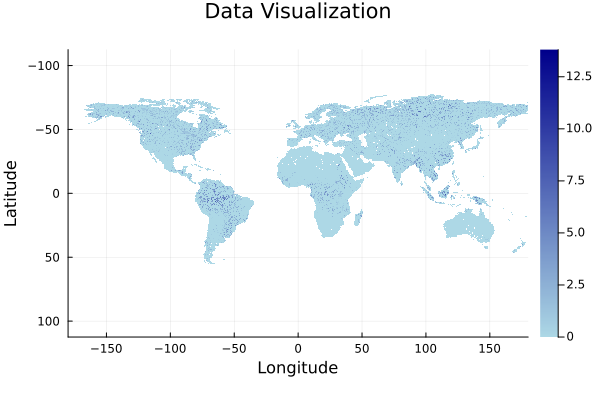

Data dimensions: (4320, 8640)
Latitude range: (-90.0, 90.0)
Longitude range: (-180.0, 180.0)


plot_basic_transposed (generic function with 3 methods)

In [20]:
function plot_basic(result, lat, lon, model_idx=1, statistic_idx=1)
    # Extract the data slice
    data_slice = result[:, :, statistic_idx, model_idx]
    
    # Print data dimensions for debugging
    println("Data dimensions: ", size(data_slice))
    println("Latitude range: ", extrema(lat))
    println("Longitude range: ", extrema(lon))
    
    # Ensure data is oriented correctly
    # In NetCDF, typically lat goes from North to South
    # We might need to flip the latitude axis
    if lat[1] > lat[end]  # If latitudes are in ascending order#descending order
        lat = reverse(lat)
        data_slice = reverse(data_slice, dims=1)
    end
    
    # Create the plot with correct orientation
    p = Plots.heatmap(lon, lat, data_slice,  # Note: removed transpose
                      xlabel="Longitude",
                      ylabel="Latitude",
                      title="Data Visualization",
                      color=:blues,
                      aspect_ratio=:equal,
                      yflip=false)  # Don't flip the y-axis
    
    return p
end

# Test the plotting with different orientations
#p1 = plot_basic(result, lat, lon, 1, 1)
#display(p1)

# If the image still appears incorrect, try these alternatives:
p2 = plot_basic(result, lat, lon, 1, 1)
display(Plots.plot(p2, yflip=true))

# Or try transposing the data:
function plot_basic_transposed(result, lat, lon, model_idx=1, statistic_idx=1)
    data_slice = result[:, :, statistic_idx, model_idx]
    p = Plots.heatmap(lon, lat, transpose(data_slice),
                      xlabel="Longitude",
                      ylabel="Latitude",
                      title="Data Visualization",
                      color=:blues,
                      aspect_ratio=:equal)
    return p
end

#p3 = plot_basic_transposed(result, lat, lon, 1, 1)
#display(p3)

In [8]:
using GLMakie
using MapTiles
using Colors

function create_interactive_map(result, lat, lon, model_idx=1, statistic_idx=1)
    # Extract the data slice and flip if needed
    data_slice = result[:, :, statistic_idx, model_idx]
    
    if lat[1] > lat[end]
        lat = reverse(lat)
        data_slice = reverse(data_slice, dims=1)
    end
    
    # Create figure
    fig = Figure(size=(1000, 800))
    
    # Create axis with proper aspect ratio
    ax = GeoAxis(fig[1,1],
                 dest="+proj=merc",  # Mercator projection to match web tiles
                 limits=(minimum(lon), maximum(lon), minimum(lat), maximum(lat)))
    
    # Add base map tiles
    image!(ax, lon, lat, 
           load_tiles(lon, lat), 
           interpolate=true)
    
    # Create heatmap of data
    hm = surface!(ax, lon, lat, data_slice,
                  colormap=:blues,
                  transparency=true,
                  opacity=0.7)
    
    # Add colorbar
    Colorbar(fig[1, 2], hm,
             label="Flood Depth",
             width=20,
             height=Relative(0.65))
    
    # Add controls for interactivity
    DataInspector(fig)
    
    return fig
end

# First, make sure your data is loaded:
ds = Dataset(filepath)
result = ds["result"][:,:,:,:]
lat = range(-90, 90, length=size(result,1))
lon = range(-180, 180, length=size(result,2))
close(ds)

# Create and display the interactive map
fig = create_interactive_map(result, lat, lon, 1, 1)
display(fig)

# Save if needed
#save("interactive_map.png", fig)
save(joinpath(nc_out_path, "results_$(rcp_value)_$(return_period_value).png"), fig)

UndefVarError: UndefVarError: `GeoAxis` not defined

In [29]:
fig

In [ ]:

# Example usage:
output_dir = "C:\\ClimateData\\Flood\\FloodDepth\\Reanalysis\\plots"
save_all_visualizations(result, lat, lon, output_dir)

# To display a single plot interactively:
display(plot_interactive_map(result, lat, lon, 1, 1))

In [ ]:
# Required packages
using NCDatasets
using Statistics
using Dates
using DataFrames
using StatsBase
using Plots
using ProgressMeter
using HypothesisTests
using Printf
using Base.Threads

"""
Process NetCDF models with chunked latitude processing
"""
function process_models_chunked_lat(directory_path::String, rcp_value::String, return_period_value::String)
    # List all files in the directory
    all_files = readdir(directory_path, join=true)
    println("Total files found in directory: ", length(all_files))
    
    # Filter for .nc4 files
    nc4_files = filter(f -> endswith(f, ".nc4"), all_files)
    println("Files with .nc4 extension: ", length(nc4_files))
    
    # Split each filename by underscore and check the specific positions
    matching_files = filter(nc4_files) do f
        parts = split(basename(f), "_")
        # Check if we have enough parts and the specific positions match
        length(parts) ≥ 9 && 
        parts[5] == rcp_value && 
        parts[9] == return_period_value
    end
    
    println("Files matching RCP '$(rcp_value)' and return period '$(return_period_value)': ", length(matching_files))
    if !isempty(matching_files)
        println("Example matching file: ", basename(matching_files[1]))
    end
    
    isempty(matching_files) && error("No files found matching criteria. Please check the directory path and file naming pattern.")
 
        
    # Get dimensions from first file
    ds = Dataset(matching_files[1])
    time_var = ds["time"][:]  # Changed from 'time' to 'time_var'
    lat = ds["lat"][:]
    lon = ds["lon"][:]
    close(ds)

    num_models = length(matching_files)
    num_time = length(time_var)  # Changed from 'time' to 'time_var'
    num_lat = length(lat)
    num_lon = length(lon)

    # Set chunk size
    chunk_size_lat = ceil(Int, num_lat / 4)

     # Initialize result array with threads
    result = Array{Float64}(undef, num_lat, num_lon, 5, num_models)
    
    # Process each model
    @showprogress "Processing models" for (model_idx, file) in enumerate(matching_files)
        println("Processing model $model_idx of $num_models: $(basename(file))")
        ds = Dataset(file)
        
        # Process latitude chunks in parallel
        lat_indices = 1:chunk_size_lat:num_lat
        
        @threads for (chunk_idx, lat_start) in collect(enumerate(lat_indices))
            lat_end = min(lat_start + chunk_size_lat - 1, num_lat)
            lat_count = lat_end - lat_start + 1
            
            # Read chunk data
            flddph_chunk = permutedims(
                ds["flddph"][:, lat_start:lat_end, :],
                [2, 1, 3]
            )
            
            # Process each grid point in chunk
            for i in 1:lat_count
                for j in 1:num_lon
                    data_ts = flddph_chunk[i, j, :]
                    
                    # Convert Missing to Float64 and handle NaN
                    data_ts_float = Float64[ismissing(x) ? NaN : Float64(x) for x in data_ts]
                    valid_idx = findall(!isnan, data_ts_float)
                    valid_data = data_ts_float[valid_idx]
                    
                    if length(valid_data) >= 2
                        # Calculate quantiles regardless of uniqueness
                        first_40 = valid_data[1:min(40, length(valid_data))]
                        result[lat_start+i-1, j, 1, model_idx] = quantile(first_40, 0.25)
                        result[lat_start+i-1, j, 2, model_idx] = quantile(first_40, 0.50)
                        result[lat_start+i-1, j, 3, model_idx] = quantile(first_40, 0.75)
                        
                        if length(unique(valid_data)) > 1
                            # Calculate slope and correlation only if there's variability
                            slopes = [(valid_data[i2] - valid_data[i1]) / (valid_idx[i2] - valid_idx[i1])
                                    for i1 in 1:length(valid_idx)
                                    for i2 in (i1+1):length(valid_idx)]
                            
                            result[lat_start+i-1, j, 4, model_idx] = median(slopes)
                            test = CorrelationTest(Float64.(valid_idx), valid_data)
                            result[lat_start+i-1, j, 5, model_idx] = pvalue(test)
                        else
                            result[lat_start+i-1, j, 4:5, model_idx] .= NaN
                        end
                    else
                        result[lat_start+i-1, j, :, model_idx] .= NaN
                    end
                end
            end
        end
        close(ds)
    end
    return result, lat, lon
end

"""
Save results to NetCDF file
"""
function save_to_netcdf(result, lat, lon, output_path, rcp_value, return_period_value)
    ds = Dataset(output_path, "c")
    
    # Define dimensions
    defDim(ds, "lat", length(lat))
    defDim(ds, "lon", length(lon))
    defDim(ds, "value", 5)
    defDim(ds, "model", size(result, 4))
    
    # Define variables
    v = defVar(ds, "result", Float64, ("lat", "lon", "value", "model"))
    v[:,:,:,:] = result
    
    # Add attributes
    ds.attrib["title"] = "Results Array Containing Statistical Analysis"
    ds.attrib["creation_date"] = string(now())
    
    close(ds)
end

# Main execution
function main()
    nc_in_path = "C:\\ClimateData\\Flood\\FloodDepth\\Future\\rawNcs\\"
    nc_out_path = "C:\\ClimateData\\Flood\\FloodDepth\\Reanalysis\\"
    rcp_value = "rcp26"
    return_period_value = "none"
    
    start_time = now()
    
    # Process data
    result, lat, lon = process_models_chunked_lat(nc_in_path, rcp_value, return_period_value)
    
    # Save results
    output_file = joinpath(nc_out_path, "results_$(rcp_value)_$(return_period_value).nc4")
    save_to_netcdf(result, lat, lon, output_file, rcp_value, return_period_value)
    
    println("Time elapsed: ", now() - start_time)
end

# Run the program
main()

Total files found in directory: 216
Files with .nc4 extension: 216
Files matching RCP 'rcp26' and return period 'none': 24
Example matching file: cama-flood_clm45_gfdl-esm2m_ewembi_rcp26_2005soc_co2_flddph_none_150arcsec_global_annual_2006_2100.nc4

In [ ]:
1-1

In [ ]:
# for multithreading use: julia --threads auto

In [6]:
using NCDatasets
using Statistics
using StatsBase
using HypothesisTests
using Dates
using ProgressMeter

"""
Compute Theil-Sen slope estimator
"""
function theil_sen_slope(x::Vector{T}, y::Vector{T}) where T<:Real
    n = length(x)
    slopes = Vector{Float64}()
    sizehint!(slopes, div(n * (n-1), 2))
    
    for i in 1:n
        for j in (i+1):n
            if x[i] != x[j]  # Avoid division by zero
                push!(slopes, (y[j] - y[i]) / (x[j] - x[i]))
            end
        end
    end
    
    return isempty(slopes) ? NaN : median(slopes)
end

"""
Process NetCDF files with chunked latitude processing
"""
function process_models_chunked_lat(directory_path::String, rcp_value::String, return_period_value::String)
    # Get list of files matching criteria
    files = filter(f -> occursin("_$(rcp_value)_.*_$(return_period_value)_", f) && endswith(f, ".nc4"),
                  readdir(directory_path, join=true))
    
    isempty(files) && error("No files found matching the specified RCP and return period criteria")
    
    # Open first file to get dimensions
    ds = Dataset(files[1])
    time = ds["time"][:]
    lat = ds["lat"][:]
    lon = ds["lon"][:]
    close(ds)
    
    num_models = length(files)
    num_time = length(time)
    num_lat = length(lat)
    num_lon = length(lon)
    
    # Initialize result array with named dimensions
    result = Array{Float64}(undef, num_lat, num_lon, 5, num_models)
    fill!(result, NaN)
    
    # Process each model
    @showprogress "Processing models" for (model_idx, file) in enumerate(files)
        ds = Dataset(file)
        chunk_size_lat = ceil(Int, num_lat / 4)
        
        # Process in latitude chunks
        for lat_start in 1:chunk_size_lat:num_lat
            lat_end = min(lat_start + chunk_size_lat - 1, num_lat)
            lat_count = lat_end - lat_start + 1
            
            # Read chunk data
            flddph_chunk = permutedims(
                ds["flddph"][1:num_lon, lat_start:lat_end, 1:num_time],
                [2, 1, 3]
            )
            
            # Process each grid point
            @threads for i in 1:lat_count
                for j in 1:num_lon
                    data_ts = @view flddph_chunk[i, j, :]
                    valid_mask = .!isnan.(data_ts)
                    valid_data = data_ts[valid_mask]
                    
                    if length(valid_data) >= 2 && length(unique(valid_data)) > 1
                        # Calculate percentiles
                        result[lat_start+i-1, j, 1, model_idx] = quantile(valid_data[1:min(40,end)], 0.25)
                        result[lat_start+i-1, j, 2, model_idx] = quantile(valid_data[1:min(40,end)], 0.50)
                        result[lat_start+i-1, j, 3, model_idx] = quantile(valid_data[1:min(40,end)], 0.75)
                        
                        # Calculate Theil-Sen slope
                        x = collect(1:length(valid_data))
                        result[lat_start+i-1, j, 4, model_idx] = theil_sen_slope(x, valid_data)
                        
                        # Calculate Spearman correlation
                        result[lat_start+i-1, j, 5, model_idx] = pvalue(SpearmanCorTest(x, valid_data))
                    elseif length(valid_data) >= 1
                        # Handle cases with single value
                        result[lat_start+i-1, j, 1:3, model_idx] .= valid_data[1]
                        result[lat_start+i-1, j, 4:5, model_idx] .= NaN
                    end
                end
            end
        end
        close(ds)
        GC.gc()  # Optional garbage collection
    end
    
    return (result=result, lat=lat, lon=lon)
end

"""
Save results to NetCDF file
"""
function save_results_to_netcdf(result, lat, lon, output_path, rcp_value, return_period_value)
    ds = Dataset(output_path, "c")
    
    # Define dimensions
    defDim(ds, "lat", length(lat))
    defDim(ds, "lon", length(lon))
    defDim(ds, "value", 5)
    defDim(ds, "model", size(result, 4))
    
    # Define variables
    v = defVar(ds, "result", Float64, ("lat", "lon", "value", "model"))
    v.attrib["long_name"] = "Statistical results"
    v.attrib["missing_value"] = NaN
    
    # Define coordinate variables
    lat_var = defVar(ds, "lat", Float64, ("lat",))
    lon_var = defVar(ds, "lon", Float64, ("lon",))
    
    value_names = ["p25", "p50", "p75", "theil_sen_slope", "spearman_p"]
    value_var = defVar(ds, "value_names", String, ("value",))
    
    # Write data
    v[:,:,:,:] = result
    lat_var[:] = lat
    lon_var[:] = lon
    value_var[:] = value_names
    
    # Add global attributes
    ds.attrib["title"] = "Statistical Analysis Results"
    ds.attrib["creation_date"] = string(Dates.now())
    ds.attrib["rcp_value"] = rcp_value
    ds.attrib["return_period_value"] = return_period_value
    
    close(ds)
end

"""
Visualize results using Plots
"""
function visualize_results(nc_file_path)
    using Plots
    
    ds = Dataset(nc_file_path)
    lat = ds["lat"][:]
    lon = ds["lon"][:]
    data = ds["result"][:,:,1,1]  # First statistic, first model
    close(ds)
    
    # Flip latitude if needed
    if lat[1] > lat[end]
        lat = reverse(lat)
        data = reverse(data, dims=1)
    end
    
    heatmap(lon, lat, data',
            xlabel="Longitude",
            ylabel="Latitude",
            title="Results Visualization",
            color=:viridis)
end



LoadError: LoadError: UndefVarError: `@threads` not defined
in expression starting at c:\Users\arikt\Documents\GitHub\juliaAndBigData\ClimateHazards\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W1sZmlsZQ==.jl:27

In [5]:
# First, make sure you have all required packages
using Pkg
Pkg.add(["NCDatasets", "Statistics", "StatsBase", "HypothesisTests", "Dates", "ProgressMeter", "Plots"])

# Import the packages
using NCDatasets
using Statistics
using StatsBase
using HypothesisTests
using Dates
using ProgressMeter
using Plots

# Set your parameters
main_directory_path = "C:/ClimateData/Flood/FloodDepth/"
input_directory_path = "$(main_directory_path)Future/RawNcs/"
rcp_value = "rcp45"                           # Replace with your RCP value
return_period_value = "none"                 # Replace with your return period
output_path = "$(main_directory_path)Reanalysis/results_$(rcp_value)_$(return_period_value).nc"

# Process the data
@time begin
    results = process_models_chunked_lat(directory_path=input_directory_path, rcp_value, return_period_value)
end

# Save the results to NetCDF
save_results_to_netcdf(results.result, results.lat, results.lon,
                      output_path, rcp_value, return_period_value)

# Visualize the results
visualize_results(output_path)

   Resolving package versions...
  No Changes to `C:\Users\arikt\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\arikt\.julia\environments\v1.10\Manifest.toml`


UndefVarError: UndefVarError: `process_models_chunked_lat` not defined

In [ ]:
# Example usage:
function main()
    directory_path = "path_to_nc_files"
    rcp_value = "rcp45"
    return_period_value = "100yr"
    output_path = "results_$(rcp_value)_$(return_period_value).nc"
    
    # Process data
    @time begin
        results = process_models_chunked_lat(directory_path, rcp_value, return_period_value)
    end
    
    # Save results
    save_results_to_netcdf(results.result, results.lat, results.lon,
                          output_path, rcp_value, return_period_value)
    
    # Visualize results
    visualize_results(output_path)
end